# Dither

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
sp.init_printing()
import scipy.fftpack as fft
import scipy.signal as sg
from ipywidgets import interact
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 4)
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams.keys()

## 1. Cuantificadores y sistemas de cuantificación

### Cuantificadores (uniformes)
1. Media Huella (midtread)
$$ Q_1(w) = \Delta \left\lfloor \frac{w}{\Delta}+\frac{1}{2} \right\rfloor  $$
2. Media Tabica o Contrahuella (midrise)
$$ Q_2(w) = \Delta \left\lfloor \frac{w}{\Delta} \right\rfloor + \frac{\Delta}{2} $$
En ambos casos
    1. en caso de saturación: $$ Q(w<w_m)=w_m,\ Q(w>w_M)=w_M $$
    2. $ w_m,\ w_M $ múltiplos de $\Delta$

Text(0.5, 0, '$w$')

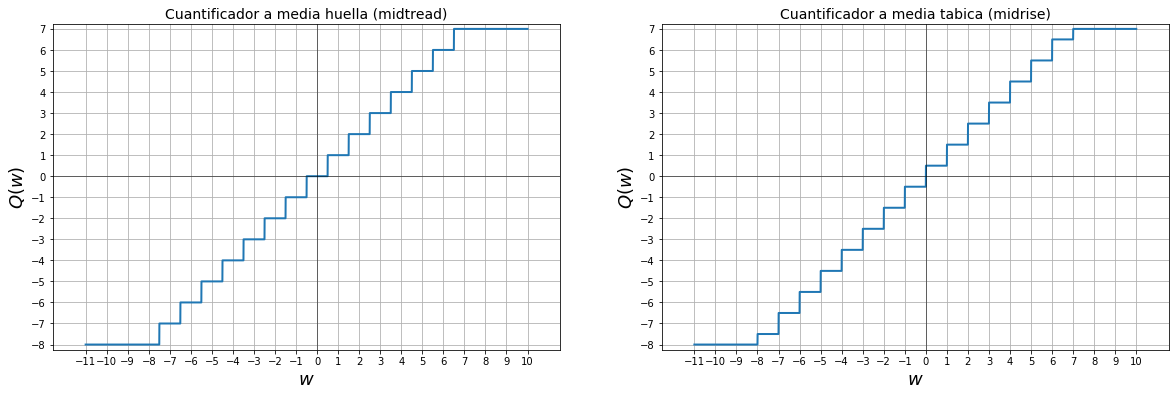

In [2]:
Delta = 1
wm = -8*Delta
wM = 7*Delta
wpm = wm-3
wpM = wM+3
w = np.linspace(wpm, wpM, 10000)
Q1 = np.select([w < wm, np.logical_and(w >= wm, w <= wM), w > wM],
               [wm, Delta*np.floor((w/Delta)+0.5), wM])
Q2 = np.select([w < wm, np.logical_and(w >= wm, w <= wM), w > wM],
               [wm, Delta*np.floor(w/Delta)+(Delta/2), wM])
plt.figure(figsize = (20, 6))
plt.subplot(121)
plt.plot(w, Q1)
plt.axis('equal')
plt.axis([wpm, wpM, wm-0.25, wM+0.25])
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.xticks(np.arange(wpm, wpM+1, Delta))
plt.yticks(np.arange(wm, wM+1, Delta))
plt.grid(True)
plt.title('Cuantificador a media huella (midtread)')
plt.ylabel(r'$Q(w)$', size=18)
plt.xlabel(r'$w$', size=18)
plt.subplot(122)
plt.plot(w, Q2)
plt.axis('equal')
plt.axis([wpm, wpM, wm-0.25, wM+0.25])
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.xticks(np.arange(wpm, wpM+1, Delta))
plt.yticks(np.arange(wm, wM+1, Delta))
plt.grid(True)
plt.title('Cuantificador a media tabica (midrise)')
plt.ylabel(r'$Q(w)$', size=18)
plt.xlabel(r'$w$', size=18)

#### Error de cuantificación
$$ e(w) := Q(w)-w $$

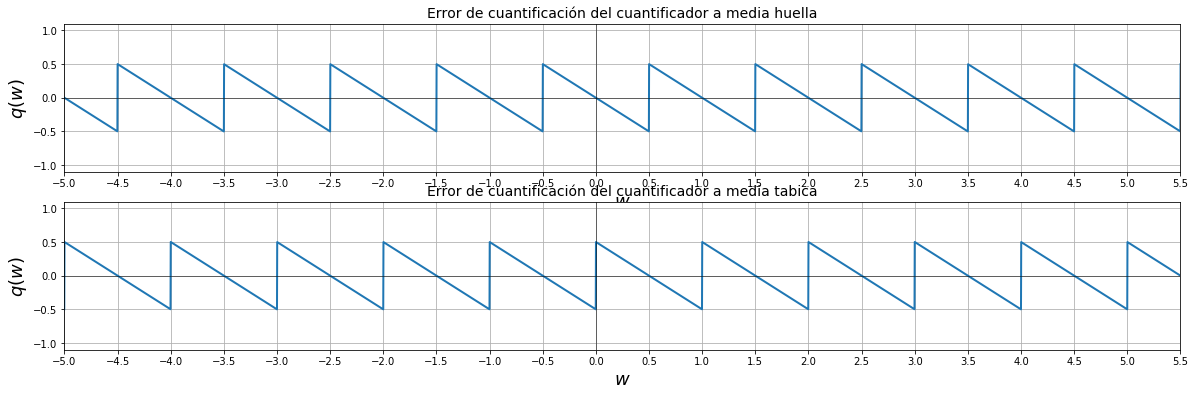

In [3]:
plt.figure(figsize=(20,6))
plt.subplot(211)
plt.plot(w, Q1-w)
plt.axis([-5, 5, -Delta-0.1, Delta+0.1])
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.title('Error de cuantificación del cuantificador a media huella')
plt.ylabel(r'$q(w)$', size=18)
plt.xlabel(r'$w$', size=18)
plt.xticks(np.arange(-5, 6, 0.5))
plt.grid(True)
plt.subplot(212)
plt.plot(w, Q2-w)
plt.axis([-5, 5, -Delta-0.1, Delta+0.1])
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.title('Error de cuantificación del cuantificador a media tabica')
plt.ylabel(r'$q(w)$', size=18)
plt.xlabel(r'$w$', size=18)
plt.xticks(np.arange(-5, 6, 0.5))
plt.grid(True)

### Sistemas cuantificadores
1.- Sin *dither*: $$ y_1 := Q(x) = x + e(x) = x + \varepsilon $$
2.- Con *dither* substractivo: $$ y_2 := Q(x+\nu) - \nu = x + e(x+\nu) = x + \varepsilon $$
3.- Con *dither* no sustractivo: $$ y_3 := Q(x+\nu) = x + \nu + e(x+\nu) = x + \varepsilon $$
donde $ x $ es la entrada del sistema, $ y_i $ la salida, $ \nu $ es ruido incorrelado con la entrada y $ \varepsilon $ el ruido total del sistema, distinto en cada caso. $ Q(x) $ es la función de cuantificación del cuantificador a media huella. 

## 2. Modelo clásico de cuantificación sin *dither*
* modelo $ \varepsilon = e(x) $, error de cuantificación incorrelado con la entrada, aditivo y uniforme.
* no hay *clipping* por saturación
* falla estrepitosamente para señales pequeñas o simples, porque no es incorrelado y, por 
* función densidad de probabilidad: $ p_\varepsilon(\varepsilon)=\Pi_\Delta(\varepsilon) $, uniforme.
* momentos: $$ E[\varepsilon^m] = \frac{\Delta^m((-1)^m+1)}{2^{m+1}(m+1)} $$
    * media: $ E[\varepsilon] = 0 $
    * varianza: $ E[\varepsilon^2] = \large{\frac{\Delta^2}{12}} $

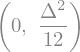

In [4]:
# variables
eps = sp.symbols('varepsilon', real=True)
Delta = sp.symbols('Delta', real=True, positive=True) 
m = sp.symbols('m', integer=True, positive=True)
# momentos
def moment(pdf, n):
    Em = sp.Integral((eps**m)*pdf, (eps, -sp.oo, sp.oo))
    return Em.subs(m, n).doit()
# función densidad de probabilidad sistema 1 (sin dither)
pdf1 = sp.Piecewise((1/Delta, sp.And((eps > -Delta/2), (eps <= Delta/2))), (0, True))
mean1 = moment(pdf1, 1)
variance1 = moment(pdf1, 2)
mean1, variance1

In [11]:
# fallo del modelo coseno 1 KHz, A = 4 LSBs, fs = 44.1 kHz
def dep(x, fs):
    hann = sg.hann(512)
    X = np.zeros(512)
    for k in range(60):
       ki = 256*k
       ke = ki + 512
       X += 10*np.log10(np.abs(fft.fft(x[ki:ke]*hann, 512)))
    X /= 60
    f = np.arange(0, 256)*fs/512
    return f, X[0:256]

def model1(a=2, bits=8):
    fs = 44100
    Ts = 1/fs
    fc = 1000
    Delta = 1
    A = a*Delta
    wm = -2**(bits-1)
    wM = 2**(bits-1)-1
    Npts = 61*256
    M = 16
    # señal continua xc(t) y muestreada sin cuantificar x[n]
    t = np.arange(0, Npts*Ts, Ts/M)
    xc = A*np.cos(2*np.pi*fc*t)
    n = np.arange(0, Npts)
    x = xc[0::M]
    # señal a cuantificar
    w = x
    # señal cuantificada y[n]
    y = np.select([w < wm, np.logical_and(w >= wm, w <= wM), w > wM],
                  [wm, Delta*np.floor((w/Delta)+0.5), wM])
    # error
    e = y - x
    # espectro de la señal cuantificada
    f, Y = dep(y, fs)
    plt.subplot(121)
    plt.plot(fs*t, xc, 'g')
    plt.step(n, y, 'r')
    plt.plot(n, e, 'b')
    plt.axhline(0, lw=0.5, color='k')
    plt.axis([0, 99, -a*Delta-0.1*A, a*Delta+0.1*A])
    plt.grid(True)
    plt.title('Coseno 1kHz y amplitud {0} muestreado a fs={1}kHz'.format(A, fs/1000))
    plt.legend(['Amplitud entrada', 'Amplitud salida', 'Error de cuantificación'], loc='lower right')
    plt.xlabel('t [ms]')
    plt.ylabel('[LSB]')
    plt.subplot(122)
    plt.plot(f*1e-3, Y)
    plt.axis([0, 22.1, -10, np.max(Y)+5])
    plt.axhline(0, lw=0.5, color='k')
    plt.title('Espectro de potencia de la señal de salida')
    plt.xlabel('f [kHz]')
    plt.ylabel('[dB]')
    plt.grid(True)    

In [12]:
interact(model1, a=(1, 256, 1), bits=(1, 12, 1))

interactive(children=(IntSlider(value=2, description='a', max=256, min=1), IntSlider(value=8, description='bit…

<function __main__.model1(a=2, bits=8)>

## 2. Modelo de cuantificación con *dither* sustractivo
* modelo $ \varepsilon = q(x + \nu) $, con $ \nu $ ruido que se añade a la señal antes de cuantificar y después se resta de la salida, por lo que es imprescindible guardarlo
* no hay *clipping* por saturación
* el candidato más sencillo que cumple la condición de Schuschman que hace que el ruido de cuantificación sea uniforme es un ruido uniforme de amplitud $ 1/\Delta $ en el intervalo $ [-\Delta/2, \Delta/2) $ 

In [16]:
# substractive dither
def model2(a=2, bits=8):
    fs = 44100
    Ts = 1/fs
    fc = 1000
    Delta = 1
    A = a*Delta
    wm = -2**(bits-1)
    wM = 2**(bits-1)-1
    Npts = 61*256
    M = 16
    t = np.arange(0, Npts*Ts, Ts/M)
    # dither
    nu = np.random.uniform(-Delta/2, Delta/2, len(t))
    # señal continua xc(t) y muestreada sin cuantificar x[n]
    xc = A*np.cos(2*np.pi*fc*t) + nu
    n = np.arange(0, Npts)
    x = xc[0::M]
    # señal a cuantificar
    w = x
    # señal cuantificada y[n]
    y = np.select([w < wm, np.logical_and(w >= wm, w <= wM), w > wM],
                  [wm, Delta*np.floor((w/Delta)+0.5), wM])
    y = y - nu[0::M]
    # error
    e = y - x
    # espectro de la señal cuantificada
    f, Y = dep(y, fs)
    plt.subplot(121)
    plt.plot(fs*t, xc, 'g')
    plt.step(n, y, 'r')
    plt.plot(n, e, 'b')
    plt.axhline(0, lw=0.5, color='k')
    plt.axis([0, 99, -a*Delta-0.1*A-(Delta/2), a*Delta+0.1*A+(Delta/2)])
    plt.grid(True)
    plt.title('Coseno 1kHz y amplitud {0} muestreado a fs={1}kHz'.format(A, fs/1000))
    plt.legend(['Amplitud entrada', 'Amplitud salida', 'Error de cuantificación'], loc='lower right')
    plt.xlabel('t [ms]')
    plt.ylabel('[LSB]')
    plt.subplot(122)
    plt.plot(f*1e-3, Y)
    plt.axis([0, 22.1, -10, np.max(Y)+5])
    plt.axhline(0, lw=0.5, color='k')
    plt.title('Espectro de potencia de la señal de salida')
    plt.xlabel('f [kHz]')
    plt.ylabel('[dB]')
    plt.grid(True)

In [17]:
interact(model2, a=(1, 256, 1), bits=(1, 12, 1))

interactive(children=(IntSlider(value=2, description='a', max=256, min=1), IntSlider(value=8, description='bit…

<function __main__.model2(a=2, bits=8)>

## 3. Modelo de cuantificación con *dither* no sustractivo
* modelo $ \varepsilon = q(x + \nu) + \nu $, con $ \nu $ ruido que se añade a la señal antes de cuantificar 
* no hay *clipping* por saturación
* el ruido de cuantificación $ \varepsilon $ NO es uniforme, en general, pero se pueden controlar sus momentos
* si $ \nu $ es uniforme, $ \varepsilon $ tiene media 0, pero la varianza depende de la señal de entrada, que se traduce en modulación del ruido
* si $ \nu $ es triangular, formada como la suma de dos v.a. uniformes independientes, $ \varepsilon $ tiene media 0 y varianza independiente de la entrada y, además, es *óptima* porque minimiza el 3er momento y, por tanto, añade la menor cantidad de nivel al ruido total

In [20]:
# not substractive dither
def model3(a=2, bits=8, ntype='uniforme'):
    fs = 44100
    Ts = 1/fs
    fc = 1000
    Delta = 1
    A = a*Delta
    wm = -2**(bits-1)
    wM = 2**(bits-1)-1
    Npts = 61*256
    M = 16
    t = np.arange(0, Npts*Ts, Ts/M)
    # dither
    if ntype == 'uniforme':
        nu = np.random.uniform(-Delta/2, Delta/2, len(t))
    else:
        nu = np.random.uniform(-Delta/2, Delta/2, len(t)) + np.random.uniform(-Delta/2, Delta/2, len(t))
    # señal continua xc(t) y muestreada sin cuantificar x[n]
    xc = A*np.cos(2*np.pi*fc*t) + nu
    n = np.arange(0, Npts)
    x = xc[0::M]
    # señal a cuantificar
    w = x + nu[0::M]
    # señal cuantificada y[n]
    y = np.select([w < wm, np.logical_and(w >= wm, w <= wM), w > wM],
                  [wm, Delta*np.floor((w/Delta)+0.5), wM])
    # error
    e = y - x
    # espectro de la señal cuantificada
    f, Y = dep(y, fs)
    plt.subplot(121)
    plt.plot(fs*t, xc, 'g')
    plt.step(n, y, 'r')
    plt.plot(n, e, 'b')
    plt.axhline(0, lw=0.5, color='k')
    plt.axis([0, 99, -a*Delta-0.1*A-(Delta), a*Delta+0.1*A+(Delta)])
    plt.grid(True)
    plt.title('Coseno 1kHz y amplitud {0} muestreado a fs={1}kHz'.format(A, fs/1000))
    plt.legend(['Amplitud entrada', 'Amplitud salida', 'Error de cuantificación'], loc='lower right')
    plt.xlabel('t [ms]')
    plt.ylabel('[LSB]')
    plt.subplot(122)
    plt.plot(f*1e-3, Y)
    plt.axis([0, 22.1, -10, np.max(Y)+5])
    plt.axhline(0, lw=0.5, color='k')
    plt.title('Espectro de potencia de la señal de salida')
    plt.xlabel('f [kHz]')
    plt.ylabel('[dB]')
    plt.grid(True)

In [22]:
interact(model3, a=(1, 256, 1), bits=(1, 12, 1), ntype=['uniforme', 'triangular'])

interactive(children=(IntSlider(value=2, description='a', max=256, min=1), IntSlider(value=8, description='bit…

<function __main__.model3(a=2, bits=8, ntype='uniforme')>